## **Phase 1 - Feature Engineering and Model Prep**

This notebook transforms chemical structure information into high-quality machine learning features. Building on the curated dataset from the discovery phase, we will generate fingerprint and descriptor-based representations of molecules to enable robust bioactivity modeling.

Our goals for this phase are:

- Read in our previous phase1_df notebook, reviewing our work and cleaning as necessary.
- Compute Morgan fingerprints from SMILES strings to represent molecular substructure.
- Generate RDKit-based physicochemical descriptors that capture key QSAR-relevant features.
- Apply other preprocessing steps such as outlier detection and collinearity checks.
- Perform feature filtering using methods such as VIF and RFE to narrow down the list of features we have generated.
- Save the final feature-engineered dataset for use in the next modeling phase.

> These engineered features will power the classifier that predicts bioactivity (IC50 ≤ 3162 nM) against our selected target: **GABA-A receptors** involved in epilepsy treatment.

This phase acts as the final staging point before model training begins.

In [1]:
# Load the previously saved dataset from our discovery notebook
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

phase1_df = pd.read_csv("../data/processed/phase1_df.csv")

# NOTE: Removing 'standard_value', 'molregno', 'standard_type', and 'standard_units' feature columns, as since we have our active classifier it is no 
# longer needed and keeping them would create data leakage and redudndancy downstream.
phase1_df = phase1_df.drop(columns = ['standard_value', 'molregno', 'standard_type', 'standard_units'])

# Sanity check - Review shape, first few rows, and describe() call
print(f"Loaded dataset with shape: {phase1_df.shape}")

print(phase1_df.head(10))

print(phase1_df.describe())

# Review active class balance
print("\n Active class balance:")
print(phase1_df['active'].value_counts())


Loaded dataset with shape: (2850, 8)
                                    canonical_smiles  mw_freebase  alogp  hba  \
0               O=c1c2cnc3cccc(O)c3c2[nH]n1-c1ccccc1       277.28   2.57  4.0   
1      CCOC(=O)c1ncc2[nH]c3ccc(OCc4ccccc4)cc3c2c1COC       390.44   4.62  5.0   
2      O=c1c2cnc3cccc(OCc4ccccc4)c3c2[nH]n1-c1ccccc1       367.41   4.45  4.0   
3            COc1cccc2ncc3c(=O)n(-c4ccccc4)[nH]c3c12       291.31   2.88  4.0   
4      O=c1c2cnc3ccc(OCc4ccccc4)cc3c2[nH]n1-c1ccccc1       367.41   4.45  4.0   
5      O=c1c2cnc3c(OCc4ccccc4)cccc3c2[nH]n1-c1ccccc1       367.41   4.45  4.0   
6  O=c1c2cnc3ccc(OCc4ccccc4)cc3c2[nH]n1-c1ccc(Cl)cc1       401.85   5.10  4.0   
7                    CCOC(=O)c1cc2c3ccccc3nc-2c[nH]1       240.26   2.84  3.0   
8                CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21       284.75   3.15  2.0   
9             CCOC(=O)c1[nH]cc2nc3ccc(OC)cc3c-2c1COC       314.34   3.00  5.0   

   hbd  rtb  qed_weighted  active  
0  2.0  1.0          0.56       1  

#### Reviewing the describe() call above I can see that our Count amounts don't match.  Let's check for missing real quick and take care of that.

In [2]:
# Missing values check first
print(phase1_df.isnull().sum())

canonical_smiles    0
mw_freebase         0
alogp               1
hba                 1
hbd                 1
rtb                 1
qed_weighted        1
active              0
dtype: int64


#### Just 1 row for some of the features, we will just remove and move on.

In [3]:
phase1_df = phase1_df.dropna()

print(phase1_df.shape)

(2849, 8)


#### Now let's keep moving forward with our agenda and compute Morgan Fingerprints from our canonical_smiles feature column.

#### We will be making a function here to convert our SMILES data from the canonical_smiles feature into 2048-bit fingerprints using RDKit.  This will allow the SMILES data to be used in modeling.

In [4]:
from rdkit import Chem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import numpy as np

# Set up the generator
morgan_gen = GetMorganGenerator(radius = 2, fpSize = 2048)

# Function to convert SMILES to 2048-bit fingerprints
def mol_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.nan # Will allow the value to be dropped later
    fp = morgan_gen.GetFingerprint(mol)
    arr = np.zeros((2048,), dtype = int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Apply to existing df
fp_array = phase1_df['canonical_smiles'].apply(mol_to_fp)

# Drop invalid SMILES rows (if any failed)
print(f"Valid fingerprints before parsing: {fp_array.notnull().sum()} / {len(fp_array)}")
phase1_df = phase1_df[fp_array.notnull()]
fp_array = fp_array[fp_array.notnull()]

# Prepping the merge with our orginal df, need to stack into a 2D array and then a df
fp_matrix = np.stack(fp_array.to_numpy())
fp_df = pd.DataFrame(fp_matrix, columns = [f'fp_{i}' for i in range(fp_matrix.shape[1])])

# Save fp_df to csv for later referencing and merging
fp_df.to_csv("../data/processed/morgan_fps.csv", index = False)

# Merge then finally into our phase1_df
phase1_df = phase1_df.reset_index(drop=True)
fp_df = fp_df.reset_index(drop=True)
phase1_df_fp = pd.concat([phase1_df, fp_df], axis = 1)

print(f"Final shape with new Morgan Fingerprints added: {phase1_df_fp.shape}")

print(phase1_df_fp.head(10))


Valid fingerprints before parsing: 2849 / 2849
Final shape with new Morgan Fingerprints added: (2849, 2056)
                                    canonical_smiles  mw_freebase  alogp  hba  \
0               O=c1c2cnc3cccc(O)c3c2[nH]n1-c1ccccc1       277.28   2.57  4.0   
1      CCOC(=O)c1ncc2[nH]c3ccc(OCc4ccccc4)cc3c2c1COC       390.44   4.62  5.0   
2      O=c1c2cnc3cccc(OCc4ccccc4)c3c2[nH]n1-c1ccccc1       367.41   4.45  4.0   
3            COc1cccc2ncc3c(=O)n(-c4ccccc4)[nH]c3c12       291.31   2.88  4.0   
4      O=c1c2cnc3ccc(OCc4ccccc4)cc3c2[nH]n1-c1ccccc1       367.41   4.45  4.0   
5      O=c1c2cnc3c(OCc4ccccc4)cccc3c2[nH]n1-c1ccccc1       367.41   4.45  4.0   
6  O=c1c2cnc3ccc(OCc4ccccc4)cc3c2[nH]n1-c1ccc(Cl)cc1       401.85   5.10  4.0   
7                    CCOC(=O)c1cc2c3ccccc3nc-2c[nH]1       240.26   2.84  3.0   
8                CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21       284.75   3.15  2.0   
9             CCOC(=O)c1[nH]cc2nc3ccc(OC)cc3c-2c1COC       314.34   3.00  5.0   



#### Good, now we will move on to generating new features with RDKit.  Since we are very early in this project yet we will just do a mass generation in a new separate df, then add our active classifier to later filter down what we need.

In [5]:
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import _descList
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

# Get ALL Descriptor names
desc_names = [desc[0] for desc in Descriptors._descList]

# Filter this list for only non-overlapping ones that we already have in phase1_df_fp
existing_features = set(phase1_df_fp.columns)
desc_names = [name for name in desc_names if name not in existing_features]

# Set up descriptor calculator
desc_calc = MolecularDescriptorCalculator(desc_names)

# Convert SMILES to molecule (needs fresh call) and calculate descriptors
def compute_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * len(desc_names)
    return list(desc_calc.CalcDescriptors(mol))

# Run on the SMILES feature column
desc_matrix = phase1_df_fp['canonical_smiles'].apply(compute_all_descriptors)
desc_array = np.vstack(desc_matrix)
rdkit_raw_df = pd.DataFrame(desc_array, columns=desc_names)

# Preview before moving on
print(f"RDKit Raw Descriptor Matrix: {rdkit_raw_df.shape}")
rdkit_raw_df.head(10)




RDKit Raw Descriptor Matrix: (2849, 217)


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.493961,12.493961,0.103761,-0.186247,0.561466,11.238095,277.283,266.195,277.085127,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.393112,12.393112,0.250537,-0.451591,0.466310,11.103448,390.439,368.263,390.157957,148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.914130,12.914130,0.131053,-0.131053,0.510602,11.142857,367.408,350.272,367.132077,136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.623107,12.623107,0.123605,-0.123605,0.617515,11.136364,291.310,278.206,291.100777,108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.828693,12.828693,0.119253,-0.119253,0.510602,11.142857,367.408,350.272,367.132077,136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,12.828693,12.828693,0.119253,-0.119253,0.510602,11.142857,367.408,350.272,367.132077,136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,12.880635,12.880635,0.159880,-0.159880,0.455474,11.206897,401.853,385.725,401.093104,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,11.672440,11.672440,0.342888,-0.342888,0.700597,10.944444,240.262,228.166,240.089878,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,12.024468,12.024468,0.028237,-0.028237,0.791645,14.600000,284.746,271.642,284.071641,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,12.210954,12.210954,0.277769,-0.403985,0.732870,11.086957,314.341,296.197,314.126657,120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Add to our new df our active classifier so we can filter
rdkit_raw_df['active'] = phase1_df_fp['active'].values

#### Good, now that we have our RDKit generated features along with our active classifier target let's do some quick cleanup on our features before we get into filtering.

In [7]:
# Drop columns that are entirely NaN
rdkit_raw_df = rdkit_raw_df.dropna(axis = 1, how = 'all')

# Drop columns that are entirely 0 (noted several in our head() call above)
rdkit_raw_df = rdkit_raw_df.loc[:, (rdkit_raw_df !=0).any(axis = 0)]

print(f"Shape after dropping suggested columns: {rdkit_raw_df.shape}")

# Run a provisional type check
print(rdkit_raw_df.dtypes)

Shape after dropping suggested columns: (2849, 207)
MaxAbsEStateIndex    float64
MaxEStateIndex       float64
MinAbsEStateIndex    float64
MinEStateIndex       float64
qed                  float64
                      ...   
fr_thiocyan          float64
fr_thiophene         float64
fr_unbrch_alkane     float64
fr_urea              float64
active                 int64
Length: 207, dtype: object


In [8]:
# Below when we ran the plots we came across some inf values, we will clip them rather than remove
rdkit_raw_df = rdkit_raw_df.replace([np.inf, -np.inf], np.nan)
rdkit_raw_df = rdkit_raw_df.fillna(rdkit_raw_df.mean())

# Check for constant columns (perfect multicollinearity) and drop those where std = 0
constant_cols = [col for col in rdkit_raw_df.columns if rdkit_raw_df[col].std() == 0]
if constant_cols:
    print(f"Dropping constant columns: {constant_cols}")
    rdkit_raw_df = rdkit_raw_df.drop(columns = constant_cols)

# Check for duplicate feature columns
rdkit_raw_df = rdkit_raw_df.loc[:, ~rdkit_raw_df.T.duplicated()]

In [9]:
from scipy.stats import skew, kurtosis

# Look into skew and kurtosis and drop columns with extremes
feature_cols = rdkit_raw_df.drop(columns = 'active')

# Calculate skew and kurtosis
skews = feature_cols.apply(skew)
kurtoses = feature_cols.apply(kurtosis)

# Define thresholds (while being generous)
skew_thresh = 8
kurt_thresh = 20

# Identify highly skewed/kurtotic columns
bad_skew_cols = skews[skews.abs() > skew_thresh].index
bad_kurt_cols = kurtoses[kurtoses.abs() > kurt_thresh].index

# Union of both
bad_dist_cols = list(set(bad_skew_cols) | set(bad_kurt_cols))

# Dropt these from our df
rdkit_raw_df.drop(columns = bad_dist_cols, inplace = True)

print(f"Dropped {len(bad_dist_cols)} extreme-skew/kurtosis columns.")
print(f"Final df shape pre-filtering: {rdkit_raw_df.shape}")


Dropped 58 extreme-skew/kurtosis columns.
Final df shape pre-filtering: (2849, 144)


#### Good, through a few quick cleanup methods we were able to eliminate almost 70 features before we even get to our more thorough feature filtering techniques.  That will help a lot in reducing the clutter these forthcoming methods sift through to get proper results pre-modeling stage.

#### Now we will prep for our feature filtering methods, merging our QSAR features with our previous work and getting our X, y ready.

In [10]:
# Concat QSAR features with our rdkit_raw_df
qsar_cols = ['mw_freebase', 'alogp', 'hbd', 'hba', 'rtb', 'qed_weighted']
qsar_df = phase1_df_fp[qsar_cols].reset_index(drop = True)
rdkit_df = rdkit_raw_df.reset_index(drop = True)

# Build X for our filtering methods
X = pd.concat([qsar_df, rdkit_df.drop(columns = 'active')], axis = 1)
y = rdkit_df['active'].values

print(X.shape)


(2849, 149)


#### We will perform one more check if you will before we get into our fitering methods now that we have brought our features together.  We will look for multicollinearity between our features, establish a list, and then drop one from each pair generated.  Doing this will help out a lot when we get to our filtering methods, reducing errors derived from running the methods themselves (divide by 0, a popular one), will really improve the results we get when filtering and allow the filtering methods to sift through what would be otherwise unnecessary or redundant features.

In [11]:
# Correlation-based pruning to eliminate multicollinearity
def pairs_based_collinearity_pruning(df, threshold = 0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    print(f"Dropping {len(to_drop)} highly correlated features (r > {threshold}):")
    return df.drop(columns = to_drop), to_drop

X_pruned, dropped_corr_cols = pairs_based_collinearity_pruning(X, threshold = 0.9)

print(X_pruned.shape)

Dropping 44 highly correlated features (r > 0.9):
(2849, 105)


#### This is a good result, 0.9 threshold is considered standard and we removed about 29% of our highly collineated features in performing this method.

#### We will now (finally) look at further feature filtration techniques such as VIF (Variance Inflation Factor), RFE (Recursive Feature Elimination), and MI Scoring (Mutual Information), to not only further pare down the large list of remaining features but to also be able to show predictability with our active classifier before we get to modeling while maintaining a safe threshold for variance.

#### First we will run the VIF (Variance Inflation Factor), with a slightly relaxed threshold.  Generally we want to keep features  with <= 10, however since we have two more filtering methods we want to use after this we don't want to be overly aggressive here.  We will start with a higher threshold to allow for a more generous pool of features for now, and can come back later if needed.

#### You can see we are also using a param of a prefilter_threshold, this will cap and remove any other outstanding collineated features that weren't caught previously.  This collineation is multivariate in nature rather than 1:1 (pairs), which is what we filtered for just prior, and is why there could potentially be outstanding collineated features we need to look for through this search before we conduct our VIF filter.


In [12]:
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function for the VIF method, two passes here.
def calculate_vif(X_input, threshold = 30, prefilter_threshold = 150):
    
    X = X_input.copy()

    # Initial scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

    # Compute initial VIF scores
    vif_scores = pd.Series(
        [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])],
        index = X.columns
    )

    # Drop features with extremely high VIF first
    high_vif_features = vif_scores[vif_scores > prefilter_threshold].index.tolist()
    if high_vif_features:
        print(f"Removing high-VIF features > {prefilter_threshold} : {high_vif_features}")
        X.drop(columns = high_vif_features, inplace = True)

    # Recalculate VIF after dropping extreme features
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

    vif_scores = pd.Series(
        [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])],
        index = X.columns
    )

    # Keep only features with VIF < threshold (30)
    filtered_cols = vif_scores[vif_scores < threshold].index.tolist()

    return filtered_cols, vif_scores
            

In [13]:
# Run the function on X_pruned
vif_filtered_cols, vif_scores = calculate_vif(X_pruned, threshold = 30, prefilter_threshold = 150)
X_vif = X_pruned[vif_filtered_cols] # final VIF-filtered dataframe

print(X_vif.shape)

Removing high-VIF features > 150 : ['mw_freebase', 'BertzCT', 'HallKierAlpha', 'SMR_VSA10', 'SMR_VSA5', 'SMR_VSA7', 'SlogP_VSA12', 'TPSA', 'EState_VSA4', 'EState_VSA5', 'EState_VSA7', 'EState_VSA8', 'VSA_EState1', 'VSA_EState2', 'NOCount', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHeteroatoms', 'NumHeterocycles', 'RingCount']
(2849, 67)


#### Good, we did a lot of work there to not only further reduce collinearity in removing another 38 redundant features (that's a further 36%) we filtered again based on variance with a threshold of 30 to have a nice grouping going forward with our other filtering methods.

#### Let's move forward with the MI Scoring method now, where we will look to filter this list down further.  So we have filtered for variance and now we just need to filter for predictability.  That's where this method will come into play.

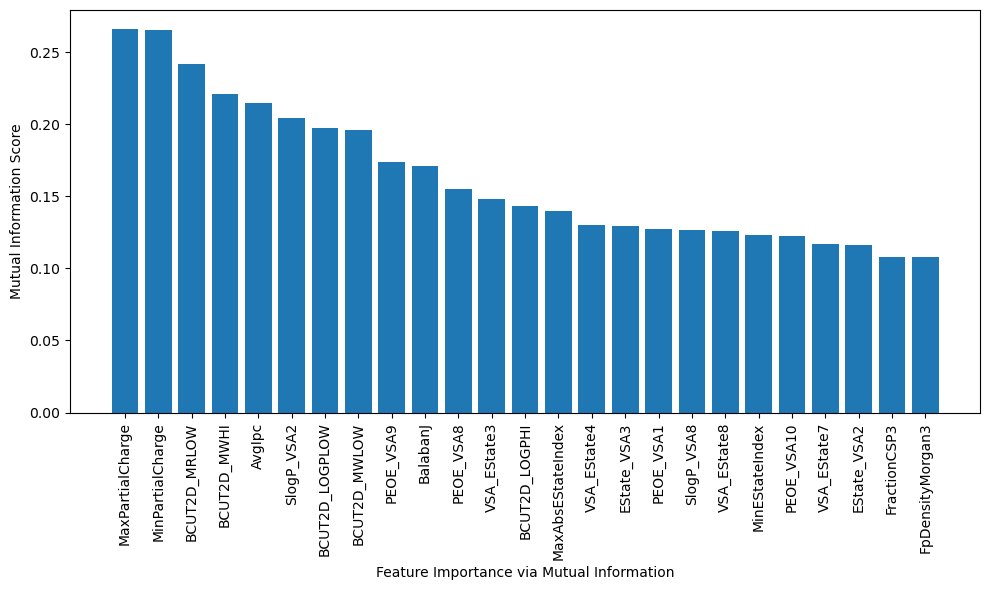

In [14]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# Compute MI Scores for each of the remaining RFECV-selected features
mi_scores = mutual_info_classif(X_vif, y, random_state = 42)
mi_df = pd.DataFrame({
    'feature' : X_vif.columns,
    'MI_Score' : mi_scores
}).sort_values(by = 'MI_Score', ascending = False)

# Get top 25 features to use in plot and also next in RFECV
top_mi_features = mi_df.head(25)['feature'].tolist()
X_rfe_input = X_vif[top_mi_features] # For later

# Plot our results
plt.figure(figsize = (10,6))
plt.bar(mi_df['feature'][:25], mi_df['MI_Score'][:25])
plt.xticks(rotation = 90)
plt.ylabel('Mutual Information Score')
plt.xlabel('Feature Importance via Mutual Information')
plt.tight_layout()
plt.show()

#### This is looking good, we are showing 25 remaining features pre-RFECV that all have a MI Score above ~0.12.  We have among this group of features a few standout predictors in MaxPartialCharge and MinPartialCharge, and they don't completely overshadow the rest of our feature group.

In [15]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Build the base model to use in XGBClassifier
xgb_model = XGBClassifier(
    n_estimators = 300,
    learning_rate = 0.05,
    max_depth = 5,
    min_child_weight = 5,
    random_state = 42,
    eval_metric = 'auc', # Main metric to keep an eye on for the project
    n_jobs = 1 # Leave at 1 to avoid kernel crashing
)

# 5-fold Stratified CV
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)


In [16]:
# Run the RFECV
rfecv = RFECV(
    estimator = xgb_model,
    step = 1,
    cv = cv,
    scoring = 'roc_auc', # Scoring for roc_auc as thhis will be one of our primary metrics.
    n_jobs = 1,
    verbose = 1,
    min_features_to_select = 15 # We want to keep at least 15 for MI Scoring selection
)

# Fit our selector
rfecv.fit(X_rfe_input, y)

Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 fe

RFECV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='auc',
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None, min_child_weight=5,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=300, n_jobs=1,
                              num_parallel_tree=None, random_state=42, ...),
      min_features_to_select=15, n_jobs=1, scoring='roc_auc', verbose=1)

In [17]:
# Acquire results
rfecv.support_

rfecv_features = X_rfe_input.columns[rfecv.support_].tolist()
X_rfecv = X_rfe_input[rfecv_features]

print(f"RFECV retained {len(rfecv_features)} features out of {X_rfe_input.shape[1]}.")
print("Top features:", rfecv_features)


RFECV retained 25 features out of 25.
Top features: ['MaxPartialCharge', 'MinPartialCharge', 'BCUT2D_MRLOW', 'BCUT2D_MWHI', 'AvgIpc', 'SlogP_VSA2', 'BCUT2D_LOGPLOW', 'BCUT2D_MWLOW', 'PEOE_VSA9', 'BalabanJ', 'PEOE_VSA8', 'VSA_EState3', 'BCUT2D_LOGPHI', 'MaxAbsEStateIndex', 'VSA_EState4', 'EState_VSA3', 'PEOE_VSA1', 'SlogP_VSA8', 'VSA_EState8', 'MinEStateIndex', 'PEOE_VSA10', 'VSA_EState7', 'EState_VSA2', 'FractionCSP3', 'FpDensityMorgan3']


#### This is great, we have 25 features all the way down from where we started.  Seeing that even though we wanted to keep at a minimum 15 features and the RFECV method still kept all 25 of our features from our MI Scoring validates our feature set for us.

#### We just need to do some housekeeping in preparing the dataframes for our modeling notebook next.

In [20]:
# Re-load the morgan fingerprint csv file to use in merging
morgan_fp = pd.read_csv("../data/processed/morgan_fps.csv")

# Reset indexes to ensure clean merge
X_rfecv = X_rfecv.reset_index(drop = True)
morgan_fp = morgan_fp.reset_index(drop = True)
y = pd.Series(y).reset_index(drop = True)

# Merge all into final dataset for our modeling ntbk coming up
phase1_modeldf = pd.concat([X_rfecv, morgan_fp], axis = 1)
phase1_modeldf['active'] = y

# Save to csv for use
phase1_modeldf.to_csv("../data/processed/phase1_modeling.csv")

# Show shape and head() call for sanity check
print(phase1_modeldf.shape)
print(phase1_modeldf.head(10))


(2849, 2074)
   MaxPartialCharge  MinPartialCharge  BCUT2D_MRLOW  BCUT2D_MWHI    AvgIpc  \
0          0.280202         -0.507167      0.481619    16.255292  2.854478   
1          0.356812         -0.488892      0.051445    16.533323  3.115749   
2          0.280202         -0.488119      0.309943    16.477394  3.100142   
3          0.280202         -0.495970      0.419726    16.465711  2.919463   
4          0.280200         -0.488891      0.306434    16.476995  3.103809   
5          0.280200         -0.486619      0.309215    16.477641  3.103723   
6          0.280200         -0.488891      0.306434    35.495692  3.102918   
7          0.354241         -0.461321      0.051934    16.532691  2.763097   
8          0.247917         -0.313200     -0.116446    35.495691  2.584084   
9          0.354624         -0.496743      0.051412    16.533274  2.929485   

   SlogP_VSA2  BCUT2D_LOGPLOW  BCUT2D_MWLOW  PEOE_VSA9  BalabanJ  ...  \
0   19.870991       -2.134106     10.138253  27.493236 

### Summary

#### In this notebook, we:

- Computed Morgan fingerprints from SMILES strings to represent molecular substructure.
- Generated RDKit-based physicochemical descriptors that capture key QSAR-relevant features.
- Applied other preprocessing steps such as outlier detection (skew and kurtosis here) and collinearity checks to ensure we were properly filtering our data.
- Performed feature filtering using methods such as VIF/MI Scoring/RFECV to narrow down the list of features we had generated to get an efficient remaining list of 25 features to merge with our Morgan Fingerprint data.
- Saved the final feature-engineered dataset for use in the next modeling phase.

> These engineered features will power the classifier that predicts bioactivity (IC50 ≤ 3162 nM) against our selected target: **GABA-A receptors** involved in epilepsy treatment.

In [19]:
import gc
gc.collect()

6888